In [3]:
import sys, os

os.getcwd()

'c:\\Users\\Public\\repos\\pfhedge\\examples'

In [4]:
import sys
import logging
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

sys.path.append("..")
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron

In [5]:
from run_ntband_fixed_cost import  NoTransactionBandNet
# If we go with float32, autograd becomes nan because:
# width in WhalleyWilmott ~ (gamma) ** 1/3, gamma is small to become zero,
# grad of width diverges (resulting in nan) at zero
torch.set_default_dtype(torch.float64)

In [64]:
## Train Model Here

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"
logging.info(f"Using device: {DEVICE}")

torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=5.5e-4, sigma=0.22), call=False, strike=1.0, maturity=20/250).to(DEVICE)

# Create your hedger
model = NoTransactionBandNet(derivative)
hedger = Hedger(model, model.inputs()).to(DEVICE)

# Fit and price
hedger.fit(derivative, n_paths=10000, n_epochs=200)
price = hedger.price(derivative, n_paths=10000)
logging.info(f"Price={price:.5e}")


[7066.885 s] Using device: cuda:0
Loss=0.0251: 100%|██████████| 200/200 [00:45<00:00,  4.36it/s]
[7113.018 s] Price=2.51630e-02


In [65]:
derivative

EuropeanOption(
  call=False, strike=1., maturity=0.0800
  (underlier): BrownianStock(sigma=0.2200, cost=0.0006, dt=0.0040, device='cuda:0')
)

In [66]:
import torch
import torch.nn.functional as F
import numpy as np

def get_no_transaction_band(model, log_m_grid, ttm=0.1, vol=0.2):
    """
    Compute lower and upper boundaries of the no-transaction band for
    various log-moneyness values, given fixed time-to-maturity and volatility.
    
    Args:
        model (NoTransactionBandNet): A trained no-transaction-band model.
        log_m_grid (Tensor): A 1D tensor of log-moneyness values.
        ttm (float): Fixed time-to-maturity for the entire grid.
        vol (float): Fixed volatility for the entire grid.
    
    Returns:
        (Tensor, Tensor): Lower boundary, Upper boundary.
                         Each of shape (len(log_m_grid),).
    """
    model.eval()  # Ensure we are in evaluation mode
    
    # 1) Build the batch input for delta/MLP: shape (N, 3) = (log_moneyness, expiry_time, volatility)
    X = torch.stack([
        log_m_grid, 
        ttm * torch.ones_like(log_m_grid),
        vol * torch.ones_like(log_m_grid)
    ], dim=-1)  # shape: [N, 3]

    # 2) Forward pass through delta and mlp
    with torch.no_grad():
        delta = model.delta(X)          # shape [N, 1] or [N]
        width = model.mlp(X)            # shape [N, 2]

    # 3) Compute band boundaries
    #    Using the same leaky_relu logic as in forward()
    min_val = delta - F.leaky_relu(width[..., 0:1])  # shape [N, 1]
    max_val = delta + F.leaky_relu(width[..., 1:2])  # shape [N, 1]
    # modification, return only the width of the no-tb-band, removeing delta from it
    # min_val = F.leaky_relu(width[..., 0:1])  # shape [N, 1]
    # max_val = F.leaky_relu(width[..., 1:2])  # shape [N, 1]


    # Squeeze extra dimension so we get shape [N]
    min_val = min_val.squeeze(-1)
    max_val = max_val.squeeze(-1)
    
    return min_val, max_val, delta.squeeze(-1)


def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()


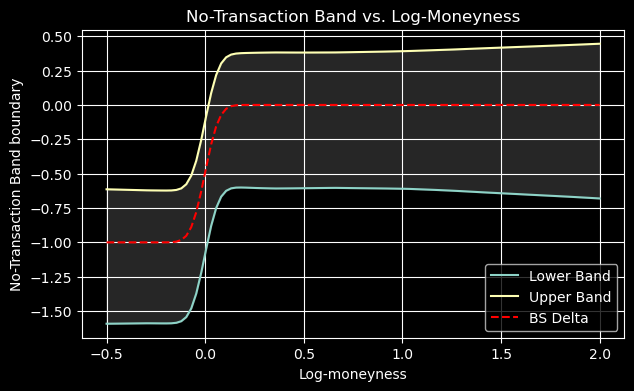

In [67]:
import matplotlib.pyplot as plt
# change this plot to have a dark theme:

plt.style.use('dark_background')

# 1) Instantiate or load your trained NoTransactionBandNet
model.eval()

# 2) Build a range of log_moneyness
log_m_grid = torch.linspace(-0.5, 2., steps=100).to(DEVICE)  # e.g. from -0.5 to 0.5

# 3) Get the band boundaries
min_vals, max_vals, delta = get_no_transaction_band(model, log_m_grid, ttm=20/250., vol=0.2)

# 4) Plot
plt.figure(figsize=(7, 4))
plt.plot(to_numpy(log_m_grid), to_numpy(min_vals), label="Lower Band")
plt.plot(to_numpy(log_m_grid), to_numpy(max_vals), label="Upper Band")
# plot BS delta in dotted Red
plt.plot(to_numpy(log_m_grid), to_numpy(delta), label="BS Delta", linestyle='--', color='red')
# shade the area between min_vals and max_vals
plt.fill_between(to_numpy(log_m_grid), to_numpy(min_vals), to_numpy(max_vals), color='gray', alpha=0.3)

plt.xlabel("Log-moneyness")
plt.ylabel("No-Transaction Band boundary")
plt.title("No-Transaction Band vs. Log-Moneyness")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
model.inputs()

['log_moneyness', 'time_to_maturity', 'volatility', 'prev_hedge']

In [22]:
import torch
import torch.nn.functional as F
import  pfhedge.autogreek as autogreek

def pricer_m(log_moneyness, strike=1.0):
    """
    Convert log_moneyness -> spot, then price the derivative with hedger.
    If log_moneyness is a 1D tensor of shape (N,),
    we loop over each element to avoid dimension mismatch in hedger.price(...).
    """
    # Ensure we handle both scalar and 1D tensor inputs
    log_moneyness = log_moneyness.view(-1)

    prices = []
    for lm in log_moneyness:
        # Convert one log_moneyness -> spot (scalar)
        spot = strike * torch.exp(lm)

        # Price with a single path simulation
        # shape of returned price is scalar (or [1]), so we store it
        p = hedger.price(derivative, init_state=(spot,), n_paths=1, enable_grad=True)
        prices.append(p)

    # Stack into shape (N,)
    return torch.stack(prices)



def get_no_transaction_band_and_greeks(
    model,
    derivative,
    log_m_grid,
    ttm=0.1,
    vol=0.2,
    strike=1.0,
    kind='autogreek'
):
    """
    Compute:
      - Lower/Upper no-transaction boundaries (min_val, max_val)
      - The model's Black-Scholes delta (model.delta)
      - The option's delta & gamma w.r.t. spot using autogreek

    Args:
        model (NoTransactionBandNet): A trained no-transaction-band model
          that uses BlackScholes(derivative) internally (model.delta).
        derivative (BaseDerivative): The same derivative used by model.delta.
        log_m_grid (Tensor): 1D tensor of log-moneyness values.
        ttm (float): Fixed time-to-maturity.
        vol (float): Fixed volatility.
        strike (float): Strike price (defaults to 1.0).

    Returns:
        (min_val, max_val, delta_bs, delta_ag, gamma_ag)
        - min_val:  shape (N,)  Lower boundary
        - max_val:  shape (N,)  Upper boundary
        - delta_bs: shape (N,)  Black–Scholes delta from `model.delta`
        - delta_ag: shape (N,)  Delta from autogreek.delta(...)
        - gamma_ag: shape (N,)  Gamma from autogreek.gamma(...)
    """
    model.eval()

    # 1) Build the input (N, 3) to feed into model.delta and model.mlp
    #    (log_moneyness, time_to_maturity, volatility)
    X = torch.stack([
        log_m_grid,
        ttm * torch.ones_like(log_m_grid),
        vol * torch.ones_like(log_m_grid)
    ], dim=-1)  # shape: [N, 3]

    N = X.shape[0]

    # 2) Forward pass to get band boundaries
    with torch.no_grad():
        # model.delta(X) is the BS delta from pfhedge.nn.BlackScholes(...)
        delta_bs = model.delta(X).squeeze(-1)  # shape: [N]
        width = model.mlp(X)                   # shape: [N, 2]

        w_lower = F.leaky_relu(width[..., 0])
        w_upper = F.leaky_relu(width[..., 1])

        min_val = delta_bs - w_lower
        max_val = delta_bs + w_upper
    
    # Call autogreek.delta on the entire batch at once:
    if kind == 'autogreek':
        delta_ag = autogreek.delta(pricer_m, log_moneyness=log_m_grid, strike=strike)  # shape: [N]
        gamma_ag = autogreek.gamma(pricer_m, log_moneyness=log_m_grid, strike=strike)  # shape: [N]
    else:
        # attach the delta and gamma to the model using theoretical Black-Scholes
        # use the simulated data to get BS delta and gamma:
        
        delta_ag = model.delta(X).squeeze(-1)  # shape: [N]
        gamma_ag = model.gamma(X).squeeze(-1)  # shape: [N]

    return min_val, max_val, delta_bs, delta_ag, gamma_ag


In [58]:
list(derivative.named_underliers())
# derivative.strike
# derivative.ttm
# derivative.vol
# derivative.cost
# derivative.sigma
# derivative.name
# derivative.strike
# derivative.ttm
# derivative.vol
# derivative.cost
# derivative.sigma


1.0

In [46]:
print(model.inputs())
# model.named_buffers('log_moneyness')

for name, buffer in model.named_buffers():
    print(f"Buffer name: {name}, Buffer value: {buffer.shape}")

# len( list(model.named_buffers()))

model.get_inputs('log_moneyness')

# get model log-moneyness from buffers of model:



# log_m_grid = model.inputs()[:, 0]
# log_m_grid.shape


['log_moneyness', 'time_to_maturity', 'volatility', 'prev_hedge']


AttributeError: 'NoTransactionBandNet' object has no attribute 'get_inputs'

In [60]:
# for name, v in model.state_dict():
#     print(name)



<bound method NoTransactionBandNet.inputs of NoTransactionBandNet(
  (delta): BSEuropeanOption(strike=1.)
  (mlp): MultiLayerPerceptron(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Identity()
  )
  (clamp): Clamp()
)>

In [23]:
import matplotlib.pyplot as plt

# 1) Instantiate or load your trained NoTransactionBandNet
model.eval()

# 2) Build a range of log_moneyness
log_m_grid = torch.linspace(-0.5, 2., steps=100).to(DEVICE)  # e.g. from -0.5 to 0.5

# 3) Get the band boundaries
min_vals, max_vals, delta_bs, delta_ag, gamma_ag = get_no_transaction_band_and_greeks(
    model, derivative, log_m_grid, ttm=20/250., vol=0.2, kind='BS')


AttributeError: 'NoTransactionBandNet' object has no attribute 'gamma'

In [24]:
import pandas as pd
# create data frame
df = pd.DataFrame({
    "gamma": gamma_ag.cpu().detach().numpy(),
    "min_vals": min_vals.cpu().detach().numpy(),
    "max_vals": max_vals.cpu().detach().numpy(),
    "delta_bs": delta_bs.cpu().detach().numpy(),
    "delta_ag": delta_ag.cpu().detach().numpy()
})  

# sort by gamma and lot no-transaction band by gamma
df = df.sort_values(by="gamma") 

# # plot gamma vs min_vals
# plt.figure(figsize=(7, 4))
# plt.plot(df["gamma"]), df["min_vals"], label="Lower Band")
# plt.plot(to_numpy(df["gamma"]), to_numpy(df["max_vals"]), label="Upper Band")
# plt.plot(to_numpy(df["gamma"]), to_numpy(df["delta_bs"]), label="BS Delta")
# plt.plot(to_numpy(df["gamma"]), to_numpy(df["delta_ag"]), label="Autogreek Delta")

# plt.xlabel("gamma")
# plt.ylabel("No-Transaction Band boundary")
# plt.title("No-Transaction Band vs. Gamma")
# plt.legend()


<Axes: xlabel='gamma'>

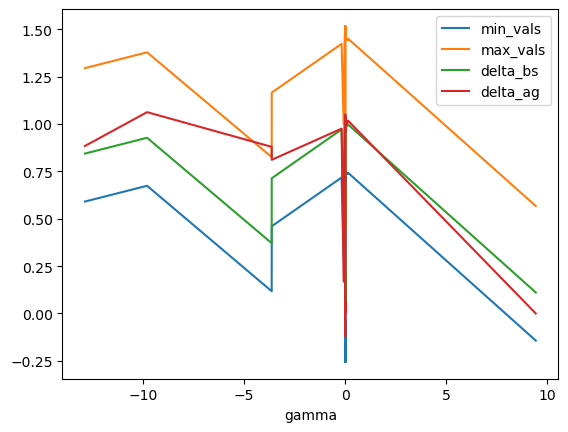

In [25]:
df.plot(x="gamma", y=["min_vals", "max_vals", "delta_bs", "delta_ag"], kind="line")


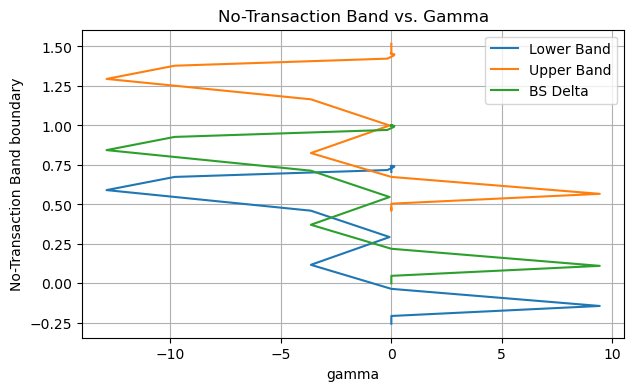

In [11]:

# 4) Plot
plt.figure(figsize=(7, 4))
plt.plot(to_numpy(gamma_ag), to_numpy(min_vals), label="Lower Band")
plt.plot(to_numpy(gamma_ag), to_numpy(max_vals), label="Upper Band")
plt.plot(to_numpy(gamma_ag), to_numpy(delta), label="BS Delta")

plt.xlabel("gamma")
plt.ylabel("No-Transaction Band boundary")
plt.title("No-Transaction Band vs. Gamma")
plt.legend()
plt.grid(True)
plt.show()

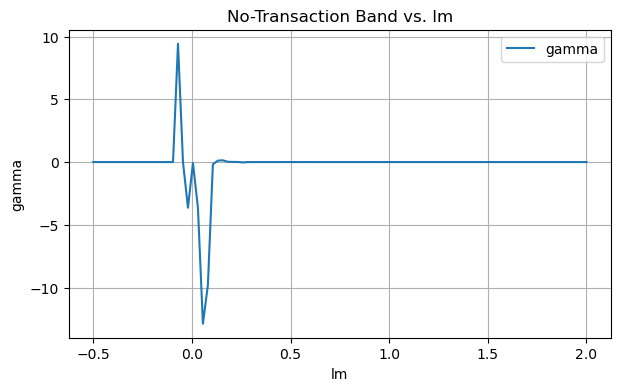

In [12]:

# 4) Plot
plt.figure(figsize=(7, 4))
plt.plot(to_numpy(log_m_grid), to_numpy(gamma_ag), label="gamma")

plt.xlabel("lm")
plt.ylabel("gamma")
plt.title("No-Transaction Band vs. lm")
plt.legend()
plt.grid(True)
plt.show()

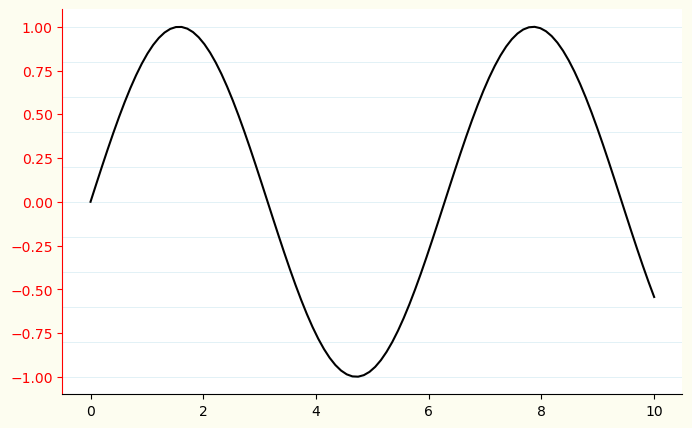

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# 1) Set a light background color (like off-white or very light grey)
fig.patch.set_facecolor("#fdfdf0")  # A faint cream color

# 2) Draw faint horizontal lines (like college-ruled lines)
#    Easiest approach is to manually add them at intervals
y_ticks = np.arange(-1.0, 1.1, 0.2)  # For example, from -1 to 1 in steps of 0.2
for y_val in y_ticks:
    ax.axhline(y=y_val, color="#add8e6", lw=0.5, zorder=0, alpha=0.5)
    # "#add8e6" is a light blue, alpha=0.5 to make it faint, lw=0.5 for a thin line

# 3) Plot your data on top
ax.plot(x, y, color="black", lw=1.5)

# 4) Style the axes
#    - Make the x-axis black
#    - Make the y-axis red
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("red")

# Hide the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Move x-axis spines position “down” a bit if you like
# (We’ll keep it standard here though)

# 5) Style the ticks
#    - X-axis ticks: black
#    - Y-axis ticks: red
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='red')

# 6) Optionally set a grid, but it might conflict with the custom lines:
#    ax.grid(False)

# 7) Show the plot
plt.show()


In [14]:
45*36

1620

In [15]:
22*36


792